In [61]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [65]:
region = "STs_right"

labels_path = "/neurospin/dico/data/deep_folding/current/datasets/dHCP_374_subjects/participants.csv"
base_path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"
    

region_path = os.path.join(base_path, region)
    
# Trouver le nom du dossier unique automatiquement
subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
if len(subdirs) != 1:
    raise RuntimeError(f"Il y a {len(subdirs)} sous-dossiers dans {region_path}, impossible de choisir automatiquement car il y a plusieurs modèles enregistrés par région.")
model_folder = subdirs[0]

# Construire les chemins complets
embedding_path = os.path.join(region_path, model_folder, "dHCP_random_embeddings", "full_embeddings.csv")

In [66]:
# Chargement et alignement
labels_df = pd.read_csv(labels_path)
embeddings = pd.read_csv(embedding_path, index_col=0)
embeddings = embeddings.loc[embeddings.index.isin(labels_df['Subject'])]
labels = labels_df.set_index('Subject').loc[embeddings.index, 'birth_age']


print("labels", labels[0:15])

print("Shape embeddings:", embeddings.shape)
print("Shape labels:    ", labels.shape)



labels ID
sub-CC00065XX08    40.428571
sub-CC00067XX10    40.000000
sub-CC00068XX11    40.428571
sub-CC00071XX06    39.857143
sub-CC00073XX08    40.714286
sub-CC00074XX09    39.714286
sub-CC00075XX10    38.571429
sub-CC00080XX07    39.285714
sub-CC00082XX09    39.428571
sub-CC00086XX13    40.571429
sub-CC00087AN14    35.714286
sub-CC00088XX15    40.285714
sub-CC00091XX10    41.285714
sub-CC00096XX15    39.571429
sub-CC00098AN17    36.571429
Name: birth_age, dtype: float64
Shape embeddings: (374, 32)
Shape labels:     (374,)


In [ ]:
# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(embeddings.values)
y = labels.values

# Validation croisée adaptée
kf = KFold(n_splits=5, shuffle=True, random_state=8)

#Recherche d'hyper‑paramètre (sans normalize)
model = LinearRegression()
param_grid = {'fit_intercept': [True, False]}
grid_search = GridSearchCV(
    model, param_grid, cv=kf,
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Prédictions & métriques de régression
y_pred = cross_val_predict(best_model, X, y, cv=kf)

mae = mean_absolute_error(y, y_pred)
r2  = r2_score(y, y_pred)


print(f"R² : {r2:.4f}")
print(f"MAE : {mae:.2f} semaines")

# Performance par split
cv_mse = -cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_r2  =  cross_val_score(best_model, X, y, cv=kf, scoring='r2')
cv_mae = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
print("CV MAEs:", -cv_mae)
print("CV MSEs:", cv_mse)
print("Mean CV MSE :", cv_mse.mean())
print("CV R²s :", cv_r2)
print("Mean CV R² :", cv_r2.mean())


GBR best params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05}
GBR MAE CV:  2.8554699465733746
R² : 0.2183
MAE : 2.85 semaines
CV MAEs: [3.00142021 2.25395271 3.18156899 2.64857531 3.19183251]
CV MSEs: [15.11530099  9.69370264 19.48299237 12.08665893 20.56792426]
Mean CV MSE : 15.389315839722451
CV R²s : [0.2634662  0.21303583 0.08620231 0.34077609 0.17146173]
Mean CV R² : 0.21498843173655963


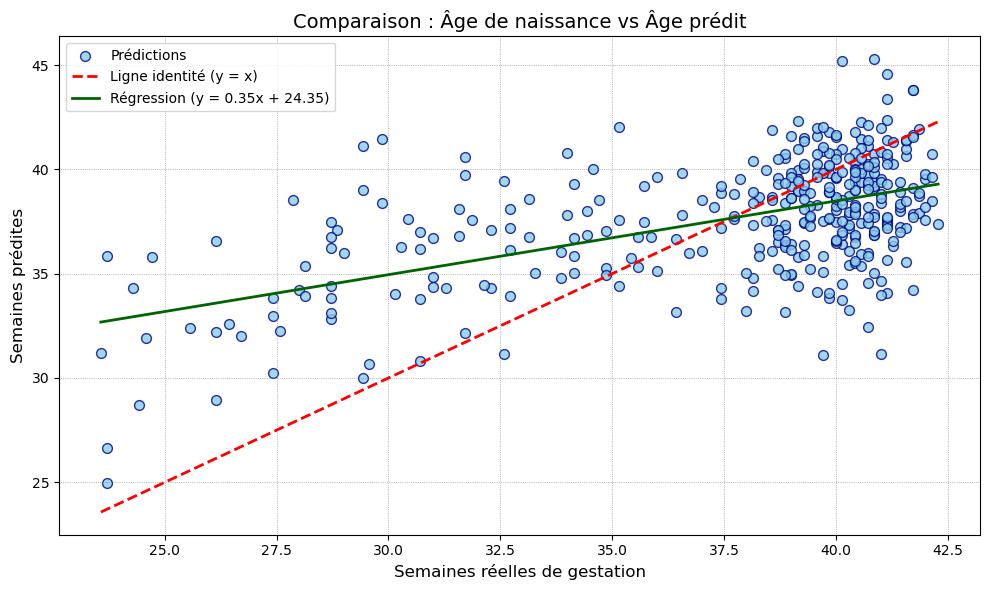

In [59]:
# Calcul de la droite de régression
coef, intercept = np.polyfit(y, y_pred, deg=1)

# Points pour tracer la droite
x_line = np.array([y.min(), y.max()])
y_line = coef * x_line + intercept

# Visualisation améliorée
plt.figure(figsize=(10, 6))

# Nuage de points : bleu clair avec bordure foncée
plt.scatter(
    y, y_pred,
    color='skyblue',
    edgecolor='navy',
    alpha=0.8,
    s=50,
    label="Prédictions"
)

# Ligne d'identité y = x
min_val, max_val = y.min(), y.max()
plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    linewidth=2,
    label="Ligne identité (y = x)"
)

# Droite de régression
plt.plot(
    x_line, y_line,
    color='darkgreen',
    linestyle='-',
    linewidth=2,
    label=f"Régression (y = {coef:.2f}x + {intercept:.2f})"
)

# Légende
plt.legend(loc='upper left')

# Labels et titre
plt.xlabel("Semaines réelles de gestation", fontsize=12)
plt.ylabel("Semaines prédites", fontsize=12)
plt.title("Comparaison : Âge de naissance vs Âge prédit", fontsize=14)

# Grille discrète
plt.grid(color='gray', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

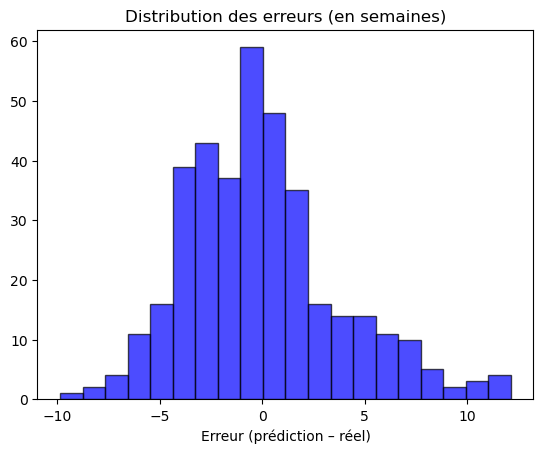

In [60]:
residus = y_pred - y
plt.hist(residus, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribution des erreurs (en semaines)")
plt.xlabel("Erreur (prédiction – réel)")
plt.show()